In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(source_dir, dest_dir, test_size=0.2, val_size=0.2):
    categories = os.listdir(source_dir)
    
    for category in categories:
        category_path = os.path.join(source_dir, category)
        images = os.listdir(category_path)
        
        # Split into training and temp
        train_images, temp_images = train_test_split(images, test_size=test_size, random_state=42)
        
        # Split temp into validation and test
        val_images, test_images = train_test_split(temp_images, test_size=val_size/(1-test_size), random_state=42)
        
        # Create category directories in destination
        for split in ['train', 'validation', 'test']:
            os.makedirs(os.path.join(dest_dir, split, category), exist_ok=True)
        
        # Move images
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(dest_dir, 'train', category, img))
        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(dest_dir, 'validation', category, img))
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(dest_dir, 'test', category, img))

# Define source and destination directories
source_directory = 'D:\\study\\Second_sem project\\10_herbs'
destination_directory = 'D:\\study\\Second_sem project\\10_herbs_splits'

# Split data
split_data(source_directory, destination_directory)


In [8]:
train_directory = 'D:\\study\\Second_sem project\\10_herbs_splits\\train'
validation_directory = 'D:\\study\\Second_sem project\\10_herbs_splits\\validation'
test_directory = 'D:\\study\\Second_sem project\\10_herbs_splits\\test'

In [9]:
# Set image size and batch size
image_size = (256, 256)
batch_size = 32

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


## create data generators


In [14]:
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9775 images belonging to 10 classes.
Found 1831 images belonging to 10 classes.
Found 614 images belonging to 10 classes.


In [13]:
validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1831 images belonging to 10 classes.


In [15]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

In [16]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [18]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/25
305/305 [==============================] - 131s 380ms/step - loss: 1.9183 - accuracy: 0.3462 - val_loss: 1.2684 - val_accuracy: 0.6508
Epoch 2/25
305/305 [==============================] - 77s 253ms/step - loss: 1.2229 - accuracy: 0.6053 - val_loss: 0.9000 - val_accuracy: 0.7451
Epoch 3/25
305/305 [==============================] - 76s 249ms/step - loss: 0.9670 - accuracy: 0.6960 - val_loss: 0.7488 - val_accuracy: 0.7884
Epoch 4/25
305/305 [==============================] - 76s 248ms/step - loss: 0.8277 - accuracy: 0.7364 - val_loss: 0.6631 - val_accuracy: 0.8070
Epoch 5/25
305/305 [==============================] - 76s 248ms/step - loss: 0.7437 - accuracy: 0.7663 - val_loss: 0.6083 - val_accuracy: 0.8240
Epoch 6/25
305/305 [==============================] - 76s 248ms/step - loss: 0.6803 - accuracy: 0.7890 - val_loss: 0.5658 - val_accuracy: 0.8377
Epoch 7/25
305/305 [==============================] - 76s 247ms/step - loss: 0.6258 - accuracy: 0.8001 - val_loss: 0.5379 - val_a

In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2f}')


20/20 [==============================] - 6s 282ms/step - loss: 0.3652 - accuracy: 0.8925
Test Accuracy: 0.89


In [20]:
# Save the model
model.save('densenet_medicinal_plants_model.h5')


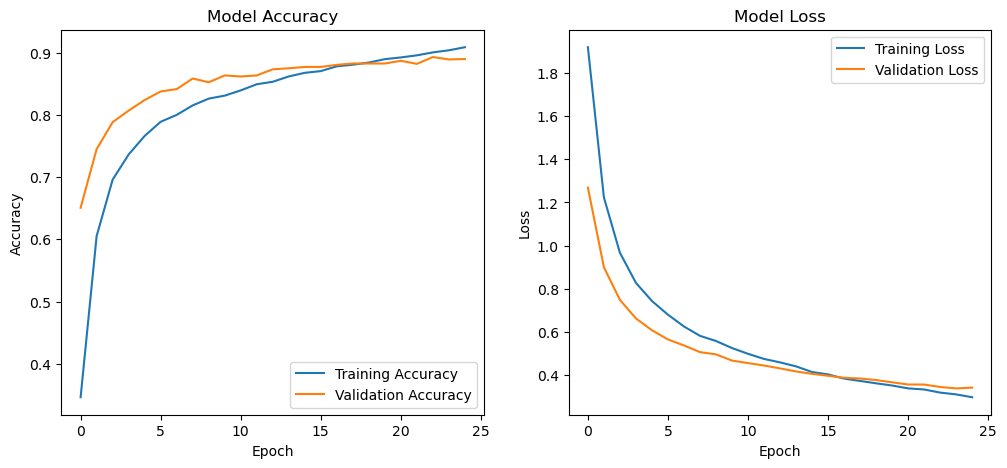

In [21]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

